In [ ]:
import pandas as pd

# Load the data
products = pd.read_csv('/content/PRODUCTS_TAKEHOME.csv')
transactions = pd.read_csv('/content/TRANSACTION_TAKEHOME.csv')
users = pd.read_csv('/content/USER_TAKEHOME.csv')

In [ ]:
# Check for missing values
print(users.isnull().sum())
print(transactions.isnull().sum())
print(products.isnull().sum())

# Check for duplicates
print(users.duplicated().sum())
print(transactions.duplicated().sum())
print(products.duplicated().sum())

# Check data types
print(users.dtypes)
print(transactions.dtypes)
print(products.dtypes)

ID                  0
CREATED_DATE        0
BIRTH_DATE       3675
STATE            4812
LANGUAGE        30508
GENDER           5892
dtype: int64
RECEIPT_ID           0
PURCHASE_DATE        0
SCAN_DATE            0
STORE_NAME           0
USER_ID              0
BARCODE           5762
FINAL_QUANTITY       0
FINAL_SALE           0
dtype: int64
CATEGORY_1         111
CATEGORY_2        1424
CATEGORY_3       60566
CATEGORY_4      778093
MANUFACTURER    226474
BRAND           226472
BARCODE           4025
dtype: int64
0
171
215
ID              object
CREATED_DATE    object
BIRTH_DATE      object
STATE           object
LANGUAGE        object
GENDER          object
dtype: object
RECEIPT_ID         object
PURCHASE_DATE      object
SCAN_DATE          object
STORE_NAME         object
USER_ID            object
BARCODE           float64
FINAL_QUANTITY     object
FINAL_SALE         object
dtype: object
CATEGORY_1       object
CATEGORY_2       object
CATEGORY_3       object
CATEGORY_4       object
MANU

Data Quality Issues:

Missing Values:
Significant missing data in critical fields:
Users Table: BIRTH_DATE (3,675), STATE (4,812), LANGUAGE (30,508), GENDER (5,892).
Transactions Table: BARCODE (5,762).
Products Table: High missing values in categories, especially CATEGORY_4 (778,093) and BRAND (226,472).

Data Types:
Fields like FINAL_SALE and FINAL_QUANTITY are stored as object types, which complicates numerical analysis.
BARCODE is a float64, which may not be appropriate since barcodes should be treated as strings.

Challenging Fields:
LANGUAGE: With over 30,000 missing values, it’s unclear how to handle this field effectively.
CATEGORY_3 and CATEGORY_4: The high number of missing values suggests inconsistency, making analysis difficult.
FINAL_SALE and FINAL_QUANTITY: Their current data types hinder calculations and visualizations.

object
12500


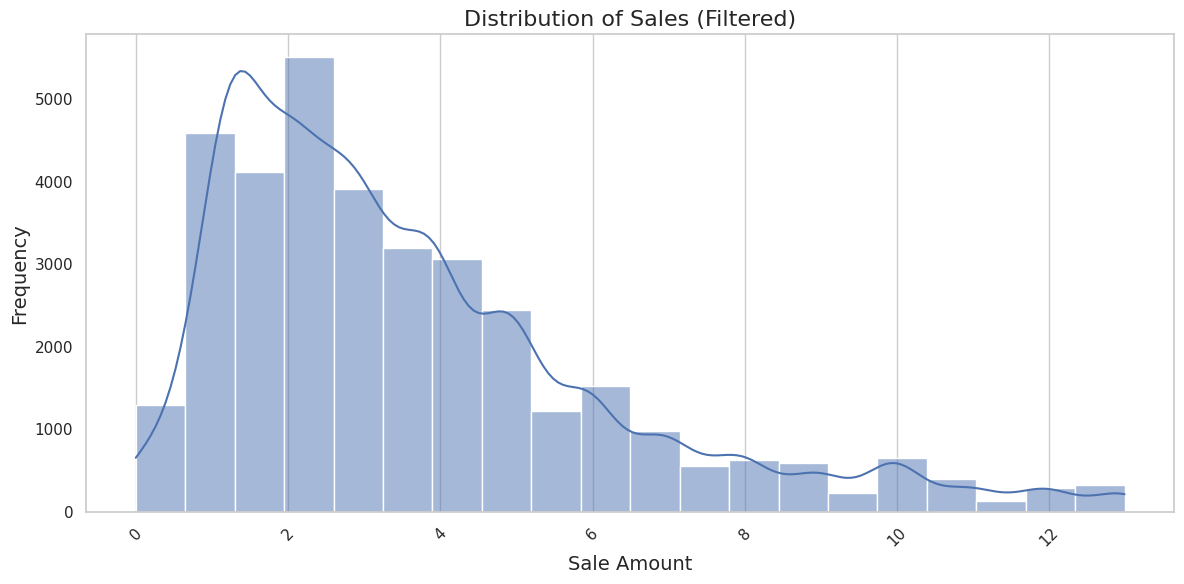

In [ ]:
import pandas as pd

# Load the transactions data
transactions = pd.read_csv('/content/TRANSACTION_TAKEHOME.csv')

# Check the data type of the FINAL_SALE column
print(transactions['FINAL_SALE'].dtype)

# Convert FINAL_SALE to numeric, forcing errors to NaN
transactions['FINAL_SALE'] = pd.to_numeric(transactions['FINAL_SALE'], errors='coerce')

# Check for any NaN values that resulted from the conversion
print(transactions['FINAL_SALE'].isnull().sum())

# Optionally, drop rows with NaN values in FINAL_SALE
transactions = transactions.dropna(subset=['FINAL_SALE'])

# Now you can proceed with the percentile calculation and visualization
percentile_95 = np.percentile(transactions['FINAL_SALE'], 95)

# Filter the data to include only sales below the 95th percentile
filtered_sales = transactions[transactions['FINAL_SALE'] <= percentile_95]

# Visualize the filtered sales distribution
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style of seaborn
sns.set(style="whitegrid")

# Visualize the filtered sales distribution
plt.figure(figsize=(12, 6))  # Increase figure size
sns.histplot(filtered_sales['FINAL_SALE'], bins=20, kde=True)  # Adjust number of bins
plt.title('Distribution of Sales (Filtered)', fontsize=16)
plt.xlabel('Sale Amount', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# Rotate x-axis labels if necessary
plt.xticks(rotation=45)

# Add gridlines for better readability
plt.grid(axis='y')

# Use tight layout to adjust spacing
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
!pip install pandas matplotlib seaborn sqlalchemy sqlite3

ERROR: Could not find a version that satisfies the requirement sqlite3 (from versions: none)
ERROR: No matching distribution found for sqlite3


In [ ]:
from sqlalchemy import create_engine

# Create SQLite database
engine = create_engine('sqlite:///fetch_data.db')

# Load data into SQL tables
users.to_sql('users', engine, index=False, if_exists='replace')
transactions.to_sql('transactions', engine, index=False, if_exists='replace')
products.to_sql('products', engine, index=False, if_exists='replace')

845552

In [ ]:
# Step 4: Load data into SQL tables
users.to_sql('users', engine, index=False, if_exists='replace')
transactions.to_sql('transactions', engine, index=False, if_exists='replace')
products.to_sql('products', engine, index=False, if_exists='replace')

# Step 6: Function to execute SQL queries
def execute_query(query):
    with engine.connect() as connection:
        result = connection.execute(text(query))  # Use text() to convert the query
        return result.fetchall()

# Step 7: SQL Queries
# 1. Top 5 brands by receipts scanned among users 21 and over
query1 = """
SELECT p.BRAND, COUNT(t.RECEIPT_ID) AS receipts_scanned
FROM transactions t
JOIN users u ON t.USER_ID = u.ID
JOIN products p ON t.BARCODE = p.BARCODE
WHERE u.BIRTH_DATE <= DATE('now', '-21 years')
GROUP BY p.BRAND
ORDER BY receipts_scanned DESC
LIMIT 5;
"""
result1 = execute_query(query1)
print("Top 5 brands by receipts scanned among users 21 and over:\n", result1)

# 2. Top 5 brands by sales among users that have had their account for at least six months
query2 = """
SELECT p.BRAND, SUM(t.FINAL_SALE) AS total_sales
FROM transactions t
JOIN users u ON t.USER_ID = u.ID
JOIN products p ON t.BARCODE = p.BARCODE
WHERE u.CREATED_DATE <= DATE('now', '-6 months')
GROUP BY p.BRAND
ORDER BY total_sales DESC
LIMIT 5;
"""
result2 = execute_query(query2)
print("Top 5 brands by sales among users that have had their account for at least six months:\n", result2)

# 3. What is the percentage of sales in the Health & Wellness category by generation?
query3 = """
SELECT
    CASE
        WHEN u.BIRTH_DATE >= DATE('now', '-25 years') THEN 'Gen Z'
        WHEN u.BIRTH_DATE >= DATE('now', '-41 years') THEN 'Millennials'
        WHEN u.BIRTH_DATE >= DATE('now', '-57 years') THEN 'Gen X'
        ELSE 'Boomers'
    END AS generation,
    SUM(t.FINAL_SALE) * 100.0 / (SELECT SUM(t2.FINAL_SALE) FROM transactions t2 JOIN products p2 ON t2.BARCODE = p2.BARCODE WHERE p2.CATEGORY_1 = 'Health & Wellness') AS percentage_sales
FROM transactions t
JOIN users u ON t.USER_ID = u.ID
JOIN products p ON t.BARCODE = p.BARCODE
WHERE p.CATEGORY_1 = 'Health & Wellness'
GROUP BY generation;
"""
result3 = execute_query(query3)
print("Fetch's power users (scanned more than 50 receipts):\n", result3)

Top 5 brands by receipts scanned among users 21 and over:
 [('NERDS CANDY', 6), ('TRIDENT', 4), ('DOVE', 4), (None, 4), ('MEIJER', 3)]
Top 5 brands by sales among users that have had their account for at least six months:
 [('CVS', 72.0), ('TRIDENT', 46.72), ('DOVE', 42.88), ('COORS LIGHT', 34.96), (None, 16.65)]
Fetch's power users (scanned more than 50 receipts):
 [('Boomers', 0.22884239285422575), ('Gen X', 0.14145523977905383), ('Millennials', 0.08729064600385754)]


In [ ]:
#4. Who are Fetch’s power users?
def execute_query(query):
    with engine.connect() as connection:
        result = connection.execute(text(query))  # Use text() to convert the query
        return result.fetchall()

# Check the number of transactions
with engine.connect() as connection:
    result = connection.execute(text("SELECT COUNT(*) FROM transactions;"))
    count = result.fetchone()[0]
    print("Total number of transactions:", count)

# Print the first few rows of the transactions table
with engine.connect() as connection:
    result = connection.execute(text("SELECT * FROM transactions LIMIT 5;"))
    for row in result:
        print(row)

# Check how many receipts each user has scanned
query_check = """
SELECT u.ID, COUNT(t.RECEIPT_ID) AS receipts_scanned
FROM users u
JOIN transactions t ON u.ID = t.USER_ID
GROUP BY u.ID
ORDER BY receipts_scanned DESC;
"""
with engine.connect() as connection:
    result = connection.execute(text(query_check))
    print("Receipts scanned by each user:")
    for row in result:
        print(row)

# Fetch's power users (scanned more than 2 receipts)
query_power_users = """
SELECT u.ID, COUNT(t.RECEIPT_ID) AS receipts_scanned
FROM users u
JOIN transactions t ON u.ID = t.USER_ID
GROUP BY u.ID
HAVING receipts_scanned > 2;
"""
result_power_users = execute_query(query_power_users)
print("Fetch's power users (scanned more than 2 receipts):", result_power_users)


Total number of transactions: 37500
('0001455d-7a92-4a7b-a1d2-c747af1c8fd3', '2024-07-20', '2024-07-20 09:50:24.206 Z', 'ALDI', '62c08877baa38d1a1f6c211a', None, 'zero', 1.49)
('000239aa-3478-453d-801e-66a82e39c8af', '2024-06-18', '2024-06-19 11:03:37.468 Z', 'FOOD LION', '63fcd7cea4f8442c3386b589', 783399746536.0, 'zero', 3.49)
('0002d8cd-1701-4cdd-a524-b70402e2dbc0', '2024-06-24', '2024-06-24 19:44:54.247 Z', 'WALMART', '5dcc6c510040a012b8e76924', 681131411295.0, 'zero', 1.46)
('00096c49-8b04-42f9-88ce-941c5e06c4a7', '2024-08-19', '2024-08-21 17:35:21.902 Z', 'TARGET', '6144f4f1f3ef696919f54b5c', 78300069942.0, 'zero', 3.59)
('0010d87d-1ad2-4e5e-9a25-cec736919d15', '2024-08-04', '2024-08-04 18:01:47.787 Z', 'ALDI', '66686fc2e04f743a096ea808', None, 'zero', 2.29)
Receipts scanned by each user:
('6528a0a388a3a884364d94dc', 6)
('62ffec490d9dbaff18c0a999', 6)
('62c09104baa38d1a1f6c260e', 5)
('610a8541ca1fab5b417b5d33', 5)
('5c366bf06d9819129dfa1118', 5)
('6682b24786cc41b000ce5e77', 4)
('

In [ ]:
#5. Query for percentage of sales in the Health & Wellness category by generation
query_health_wellness_percentage = """
SELECT
    CASE
        WHEN u.BIRTH_DATE >= DATE('now', '-25 years') THEN 'Gen Z'
        WHEN u.BIRTH_DATE >= DATE('now', '-41 years') THEN 'Millennials'
        WHEN u.BIRTH_DATE >= DATE('now', '-57 years') THEN 'Gen X'
        ELSE 'Boomers'
    END AS generation,
    SUM(t.FINAL_SALE) AS total_sales,
    (SUM(t.FINAL_SALE) * 100.0 / (SELECT SUM(t2.FINAL_SALE)
                                    FROM transactions t2
                                    JOIN products p2 ON t2.BARCODE = p2.BARCODE
                                    WHERE p2.CATEGORY_1 = 'Health & Wellness')) AS percentage_sales
FROM transactions t
JOIN users u ON t.USER_ID = u.ID
JOIN products p ON t.BARCODE = p.BARCODE
WHERE p.CATEGORY_1 = 'Health & Wellness'
GROUP BY generation;
"""

result_health_wellness_percentage = execute_query(query_health_wellness_percentage)
print("Percentage of sales in the Health & Wellness category by generation:\n", result_health_wellness_percentage)


Percentage of sales in the Health & Wellness category by generation:
 [('Boomers', 94.85, 0.22884239285422575), ('Gen X', 58.629999999999995, 0.14145523977905383), ('Millennials', 36.18, 0.08729064600385754)]


In [ ]:
#6. Check for any transactions in 2024
query_check_2024_transactions = """
SELECT COUNT(*) AS transaction_count
FROM transactions
WHERE strftime('%Y', PURCHASE_DATE) = '2024';
"""
transactions_2024_count = execute_query(query_check_2024_transactions)
print("Number of transactions in 2024:", transactions_2024_count)

# Check distinct years in the PURCHASE_DATE
query_distinct_years = """
SELECT DISTINCT strftime('%Y', PURCHASE_DATE) AS year
FROM transactions;
"""
distinct_years = execute_query(query_distinct_years)
print("Distinct years in PURCHASE_DATE:", distinct_years)





# Check for any transactions in 2023
query_check_2023_transactions = """
SELECT COUNT(*) AS transaction_count
FROM transactions
WHERE strftime('%Y', PURCHASE_DATE) = '2023';
"""
transactions_2023_count = execute_query(query_check_2023_transactions)
print("Number of transactions in 2023:", transactions_2023_count)

# Check distinct years in the PURCHASE_DATE
query_distinct_years = """
SELECT DISTINCT strftime('%Y', PURCHASE_DATE) AS year
FROM transactions;
"""
distinct_years = execute_query(query_distinct_years)
print("Distinct years in PURCHASE_DATE:", distinct_years)

Number of transactions in 2024: [(37500,)]
Distinct years in PURCHASE_DATE: [('2024',)]
Number of transactions in 2023: [(0,)]
Distinct years in PURCHASE_DATE: [('2024',)]
